# Selection & Preprocessing
### Author: Terence Kaplan

In [1]:
# Load necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Read the CSV file into a data frame
df_all_var = pd.read_csv('./df_all_var.csv')

# Inspect the head of the file
pd.set_option('display.max_columns', None)
df_all_var.head()

,Timestamp,From Bank,From Account,To Bank,To Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Digit Sum Amount Received,Digit Sum Amount Paid,Count Zeros Amount Received,Count Zeros Amount Paid,From Account Average Digit Sum Paid,From Account Average Count Zeros Paid,From Account Average Digit Sum Received,From Account Average Count Zeros Received,To Account Average Digit Sum Paid,To Account Average Count Zeros Paid,To Account Average Digit Sum Received,To Account Average Count Zeros Received,From Account Average Zero Digit Ratio Paid,From Account Average Zero Digit Ratio Received,To Account Average Zero Digit Ratio Paid,To Account Average Zero Digit Ratio Received,From Account Amount Paid Min,From Account Amount Paid Mean,From Account Amount Paid Median,From Account Amount Paid Max,From Account Amount Paid Sum,From Account Amount Paid Count,To Account Amount Received Min,To Account Amount Received Mean,To Account Amount Received Median,To Account Amount Received Max,To Account Amount Received Sum,To Account Amount Received Count,From Account Average Amount Paid in ACH,From Account Average Amount Paid in Bitcoin,From Account Average Amount Paid in Cash,From Account Average Amount Paid in Cheque,From Account Average Amount Paid in Credit Card,From Account Average Amount Paid in Reinvestment,From Account Average Amount Paid in Wire,To Account Average Amount Received in ACH,To Account Average Amount Received in Bitcoin,To Account Average Amount Received in Cash,To Account Average Amount Received in Cheque,To Account Average Amount Received in Credit Card,To Account Average Amount Received in Reinvestment,To Account Average Amount Received in Wire,From Account Paid Transaction Count,From Account Received Transaction Count,To Account Paid Transaction Count,To Account Received Transaction Count,From Account Average Amount Paid,From Account Std Dev Amount Paid,From Account Average Amount Received,From Account Std Dev Amount Received,To Account Average Amount Paid,To Account Std Dev Amount Paid,To Account Average Amount Received,To Account Std Dev Amount Received,Within Bank,Day,Hour,Minute
0,2022-09-01,121,8123FB9B0,121,8123FB9B0,12.677957,Saudi Riyal,12.677957,Saudi Riyal,Reinvestment,0,21,21,4,4,24.000000,4.333333,26.071429,4.857143,24.000000,4.333333,26.071429,4.857143,0.485185,0.488276,0.485185,0.488276,12.677957,12.677957,12.677957,12.677957,12.677957,1.0,12.677957,12.677957,12.677957,12.677957,12.677957,1.0,2058.070954,NaN,NaN,NaN,NaN,113.920650,NaN,NaN,NaN,NaN,2.543906e+03,27771.013808,113.920650,NaN,3.0,14.0,3.0,14.0,761.970751,1127.012371,3998.701632,7731.948289,761.970751,1127.012371,3998.701632,7731.948289,1,1,0,0
1,2022-09-01,25170,8095AF7C0,25170,8095AF7C0,2977.670116,Canadian Dollar,2977.670116,Canadian Dollar,Reinvestment,0,26,26,4,4,19.666667,4.666667,18.500000,4.000000,19.666667,4.666667,18.500000,4.000000,0.500000,0.450000,0.500000,0.450000,2977.670116,2977.670116,2977.670116,2977.670116,2977.670116,1.0,2977.670116,2977.670116,2977.670116,2977.670116,2977.670116,1.0,2089.542390,NaN,NaN,NaN,NaN,1493.562942,NaN,NaN,NaN,NaN,NaN,NaN,1493.562942,NaN,3.0,2.0,3.0,2.0,1692.222758,1523.473423,1493.562942,2098.844493,1692.222758,1523.473423,1493.562942,2098.844493,1,1,0,0
2,2022-09-01,25665,809A7D4B0,24779,809189BA0,74.103124,Canadian Dollar,74.103124,Canadian Dollar,Credit Card,0,29,29,4,4,17.700000,4.700000,22.000000,6.000000,27.017544,4.438596,18.463415,4.658537,0.582143,0.600000,0.450642,0.527153,74.103124,74.103124,74.103124,74.103124,74.103124,1.0,74.103124,74.103124,74.103124,74.103124,74.103124,1.0,NaN,NaN,NaN,NaN,63.796792,NaN,NaN,156.286217,NaN,3659.92965,5.899356e+04,52.150456,34307.393825,NaN,10.0,1.0,57.0,41.0,63.796792,85.324934,2089.542390,NaN,6466.005467,11491.606058,13844.942578,69680.093067,0,1,0,0
3,2022-09-01,32317,800D4E490,12004,800D4E750,13886.360391,Euro,13886.360391,Euro,Wire,0,30,30,5,5,30.000000,5.000000,NaN,NaN,26.000000,4.888889,25.500000,4.50000

### Dealing with NaN-Values

In [3]:
# Number of NaN's for each variable
pd.set_option('display.max_rows', None)
num_nan = df_all_var.isna().sum()

In [4]:
# Show all variables consisting of NaN's
df_all_var.columns[df_all_var.isna().any()]

Index(['From Account Average Digit Sum Received',
       'From Account Average Count Zeros Received',
       'To Account Average Digit Sum Paid',
       'To Account Average Count Zeros Paid',
       'From Account Average Zero Digit Ratio Received',
       'To Account Average Zero Digit Ratio Paid',
       'From Account Average Amount Paid in ACH',
       'From Account Average Amount Paid in Bitcoin',
       'From Account Average Amount Paid in Cash',
       'From Account Average Amount Paid in Cheque',
       'From Account Average Amount Paid in Credit Card',
       'From Account Average Amount Paid in Reinvestment',
       'From Account Average Amount Paid in Wire',
       'To Account Average Amount Received in ACH',
       'To Account Average Amount Received in Bitcoin',
       'To Account Average Amount Received in Cash',
       'To Account Average Amount Received in Cheque',
       'To Account Average Amount Received in Credit Card',
       'To Account Average Amount Received in Re

In [5]:
# Replace NaN's of all variables by zero except variables computing standard deviations

# Define list of all variable names
all_var = df_all_var.columns.tolist()

# Define list of all variables computing standard deviations
std_dev_var = [
    "From Account Std Dev Amount Paid", 
    "From Account Std Dev Amount Received", 
    "To Account Std Dev Amount Paid", 
    "To Account Std Dev Amount Received"
]

# Define list of all variables containing NaN's which will be replaced by zero
var_nan = [var for var in all_var if var not in std_dev_var]

# Replace NaN's by zero
df_all_var[var_nan] = df_all_var[var_nan].fillna(0)

In [6]:
# Show means of the variables for standard deviations
df_all_var['From Account Std Dev Amount Paid'].mean(), df_all_var['To Account Std Dev Amount Received'].mean(),df_all_var['From Account Std Dev Amount Received'].mean(),df_all_var['To Account Std Dev Amount Paid'].mean()

(1386710.0225969055, 823986.9740440819, 957094.4804609986, 913135.9961471147)

In [7]:
# For all NaN's of "From Account Std Dev Amount Paid" and "To Account Std Dev Amount Received" with exactly one transaction

# Compute their means
mean_from_account_std_dev_amount_paid = df_all_var['From Account Std Dev Amount Paid'].mean() 
mean_to_account_std_dev_amount_received = df_all_var['To Account Std Dev Amount Received'].mean()

# Replace the NaN's by the corresponding variable mean
df_all_var['From Account Std Dev Amount Paid'].fillna(mean_from_account_std_dev_amount_paid, inplace=True)
df_all_var['To Account Std Dev Amount Received'].fillna(mean_to_account_std_dev_amount_received, inplace=True)

In [8]:
# Compute mean of variable "From Account Std Dev Amount Received"
mean_from_account_std_dev_amount_received = df_all_var['From Account Std Dev Amount Received'].mean()

# Replace NaN by the mean of its variable if account received exactly one transaction
df_all_var.loc[(df_all_var['From Account Std Dev Amount Received'].isna()) & 
               (df_all_var['From Account Received Transaction Count'] == 1), 
               'From Account Std Dev Amount Received'] = mean_from_account_std_dev_amount_received

# Replace NaN by zero if account received no transaction
df_all_var.loc[(df_all_var['From Account Std Dev Amount Received'].isna()) & 
               (df_all_var['From Account Received Transaction Count'] == 0), 
               'From Account Std Dev Amount Received'] = 0

In [9]:
# Compute mean of variable "To Account Std Dev Amount Paid" 
mean_to_account_std_dev_amount_paid = df_all_var['To Account Std Dev Amount Paid'].mean()

# Replace NaN by the mean of its variable if account sent exactly one transaction
df_all_var.loc[(df_all_var['To Account Std Dev Amount Paid'].isna()) & 
               (df_all_var['To Account Paid Transaction Count'] == 1), 
               'To Account Std Dev Amount Paid'] = mean_to_account_std_dev_amount_paid

# Replace NaN by zero if account sent no transaction
df_all_var.loc[(df_all_var['To Account Std Dev Amount Paid'].isna()) & 
               (df_all_var['To Account Paid Transaction Count'] == 0), 
               'To Account Std Dev Amount Paid'] = 0

In [10]:
# CHECK RESULTS - Replace NaN-values

# Specific account sent and received one transaction -> hence both variables should show mean of std dev
test_from = df_all_var[df_all_var['From Account'] == '800B701A0'] 
test_to = df_all_var[df_all_var['To Account'] == '800B701A0'] 

# Specific account sent one transaction but received none -> paid equals mean std dev, received std dev is zero
test2_from = df_all_var[df_all_var['From Account'] == '800D4E490'] 

### Dropping of Irrelevant Variables

In [11]:
# As information is already given by other variables
df_all_var = df_all_var.drop(columns=['Timestamp', 'From Bank', 'To Bank'])

# As information should not be considered for the models
df_all_var = df_all_var.drop(columns=['From Account', 'To Account'])

In [12]:
# For how many transactions is "Amount Paid" not equal to "Amount Received"
unequal_payments = df_all_var[df_all_var['Amount Received'] != df_all_var['Amount Paid']]
len(unequal_payments)
unequal_payments.describe()

# Remove those transactions
df_all_var = df_all_var[df_all_var['Amount Received'] == df_all_var['Amount Paid']]

# For how many transactions is "Payment Currency" not equal to "Receiving Currency"
unequal_currency = df_all_var[df_all_var['Payment Currency'] != df_all_var['Receiving Currency']]
len(unequal_currency)
unequal_currency.describe()

# Remove those transactions
df_all_var = df_all_var[df_all_var['Payment Currency'] == df_all_var['Receiving Currency']]

# Drop the variables "Amount Received" and "Receiving Currency" as they became redundant
df_all_var = df_all_var.drop(columns=['Amount Received', 'Receiving Currency'])
df_all_var.head()

,Amount Paid,Payment Currency,Payment Format,Is Laundering,Digit Sum Amount Received,Digit Sum Amount Paid,Count Zeros Amount Received,Count Zeros Amount Paid,From Account Average Digit Sum Paid,From Account Average Count Zeros Paid,From Account Average Digit Sum Received,From Account Average Count Zeros Received,To Account Average Digit Sum Paid,To Account Average Count Zeros Paid,To Account Average Digit Sum Received,To Account Average Count Zeros Received,From Account Average Zero Digit Ratio Paid,From Account Average Zero Digit Ratio Received,To Account Average Zero Digit Ratio Paid,To Account Average Zero Digit Ratio Received,From Account Amount Paid Min,From Account Amount Paid Mean,From Account Amount Paid Median,From Account Amount Paid Max,From Account Amount Paid Sum,From Account Amount Paid Count,To Account Amount Received Min,To Account Amount Received Mean,To Account Amount Received Median,To Account Amount Received Max,To Account Amount Received Sum,To Account Amount Received Count,From Account Average Amount Paid in ACH,From Account Average Amount Paid in Bitcoin,From Account Average Amount Paid in Cash,From Account Average Amount Paid in Cheque,From Account Average Amount Paid in Credit Card,From Account Average Amount Paid in Reinvestment,From Account Average Amount Paid in Wire,To Account Average Amount Received in ACH,To Account Average Amount Received in Bitcoin,To Account Average Amount Received in Cash,To Account Average Amount Received in Cheque,To Account Average Amount Received in Credit Card,To Account Average Amount Received in Reinvestment,To Account Average Amount Received in Wire,From Account Paid Transaction Count,From Account Received Transaction Count,To Account Paid Transaction Count,To Account Received Transaction Count,From Account Average Amount Paid,From Account Std Dev Amount Paid,From Account Average Amount Received,From Account Std Dev Amount Received,To Account Average Amount Paid,To Account Std Dev Amount Paid,To Account Average Amount Received,To Account Std Dev Amount Received,Within Bank,Day,Hour,Minute
0,12.677957,Saudi Riyal,Reinvestment,0,21,21,4,4,24.000000,4.333333,26.071429,4.857143,24.000000,4.333333,26.071429,4.857143,0.485185,0.488276,0.485185,0.488276,12.677957,12.677957,12.677957,12.677957,12.677957,1.0,12.677957,12.677957,12.677957,12.677957,12.677957,1.0,2058.070954,0.0,0.000000,0.000000,0.000000,113.920650,0.000000,0.000000,0.0,0.00000,2.543906e+03,27771.013808,113.920650,0.000000,3.0,14.0,3.0,14.0,761.970751,1.127012e+03,3998.701632,7731.948289,761.970751,1127.012371,3998.701632,7731.948289,1,1,0,0
1,2977.670116,Canadian Dollar,Reinvestment,0,26,26,4,4,19.666667,4.666667,18.500000,4.000000,19.666667,4.666667,18.500000,4.000000,0.500000,0.450000,0.500000,0.450000,2977.670116,2977.670116,2977.670116,2977.670116,2977.670116,1.0,2977.670116,2977.670116,2977.670116,2977.670116,2977.670116,1.0,2089.542390,0.0,0.000000,0.000000,0.000000,1493.562942,0.000000,0.000000,0.0,0.00000,0.000000e+00,0.000000,1493.562942,0.000000,3.0,2.0,3.0,2.0,1692.222758,1.523473e+03,1493.562942,2098.844493,1692.222758,1523.473423,1493.562942,2098.844493,1,1,0,0
2,74.103124,Canadian Dollar,Credit Card,0,29,29,4,4,17.700000,4.700000,22.000000,6.000000,27.017544,4.438596,18.463415,4.658537,0.582143,0.600000,0.450642,0.527153,74.103124,74.103124,74.103124,74.103124,74.103124,1.0,74.103124,74.103124,74.103124,74.103124,74.103124,1.0,0.000000,0.0,0.000000,0.000000,63.796792,0.000000,0.000000,156.286217,0.0,3659.92965,5.899356e+04,52.150456,34307.393825,0.000000,10.0,1.0,57.0,41.0,63.796792,8.532493e+01,2089.542390,957094.480461,6466.005467,11491.606058,13844.942578,69680.093067,0,1,0,0
3,13886.360391,Euro,Wire,0,30,30,5,5,30.000000,5.000000,0.000000,0.000000,26.000000,4.888889,25.500000,4.500000,0.454545,0.000000,0.485602,0.458417,13886.360391,13886.360391,13886.360391,13886.360391,13886.360391,1.0,13886.360391,13886.360391,13886.360391,13886.360391,13886.360391,1.0,0.000000,0.0,0.000000,0.000000,0.000

### Transformation of Categorical Variables to Dummies

In [13]:
# Convert to categorical variables
variables_character = ['Payment Currency', 'Payment Format']

for variable in variables_character:
    df_all_var[variable] = df_all_var[variable].astype('category')
df_all_var.head()

,Amount Paid,Payment Currency,Payment Format,Is Laundering,Digit Sum Amount Received,Digit Sum Amount Paid,Count Zeros Amount Received,Count Zeros Amount Paid,From Account Average Digit Sum Paid,From Account Average Count Zeros Paid,From Account Average Digit Sum Received,From Account Average Count Zeros Received,To Account Average Digit Sum Paid,To Account Average Count Zeros Paid,To Account Average Digit Sum Received,To Account Average Count Zeros Received,From Account Average Zero Digit Ratio Paid,From Account Average Zero Digit Ratio Received,To Account Average Zero Digit Ratio Paid,To Account Average Zero Digit Ratio Received,From Account Amount Paid Min,From Account Amount Paid Mean,From Account Amount Paid Median,From Account Amount Paid Max,From Account Amount Paid Sum,From Account Amount Paid Count,To Account Amount Received Min,To Account Amount Received Mean,To Account Amount Received Median,To Account Amount Received Max,To Account Amount Received Sum,To Account Amount Received Count,From Account Average Amount Paid in ACH,From Account Average Amount Paid in Bitcoin,From Account Average Amount Paid in Cash,From Account Average Amount Paid in Cheque,From Account Average Amount Paid in Credit Card,From Account Average Amount Paid in Reinvestment,From Account Average Amount Paid in Wire,To Account Average Amount Received in ACH,To Account Average Amount Received in Bitcoin,To Account Average Amount Received in Cash,To Account Average Amount Received in Cheque,To Account Average Amount Received in Credit Card,To Account Average Amount Received in Reinvestment,To Account Average Amount Received in Wire,From Account Paid Transaction Count,From Account Received Transaction Count,To Account Paid Transaction Count,To Account Received Transaction Count,From Account Average Amount Paid,From Account Std Dev Amount Paid,From Account Average Amount Received,From Account Std Dev Amount Received,To Account Average Amount Paid,To Account Std Dev Amount Paid,To Account Average Amount Received,To Account Std Dev Amount Received,Within Bank,Day,Hour,Minute
0,12.677957,Saudi Riyal,Reinvestment,0,21,21,4,4,24.000000,4.333333,26.071429,4.857143,24.000000,4.333333,26.071429,4.857143,0.485185,0.488276,0.485185,0.488276,12.677957,12.677957,12.677957,12.677957,12.677957,1.0,12.677957,12.677957,12.677957,12.677957,12.677957,1.0,2058.070954,0.0,0.000000,0.000000,0.000000,113.920650,0.000000,0.000000,0.0,0.00000,2.543906e+03,27771.013808,113.920650,0.000000,3.0,14.0,3.0,14.0,761.970751,1.127012e+03,3998.701632,7731.948289,761.970751,1127.012371,3998.701632,7731.948289,1,1,0,0
1,2977.670116,Canadian Dollar,Reinvestment,0,26,26,4,4,19.666667,4.666667,18.500000,4.000000,19.666667,4.666667,18.500000,4.000000,0.500000,0.450000,0.500000,0.450000,2977.670116,2977.670116,2977.670116,2977.670116,2977.670116,1.0,2977.670116,2977.670116,2977.670116,2977.670116,2977.670116,1.0,2089.542390,0.0,0.000000,0.000000,0.000000,1493.562942,0.000000,0.000000,0.0,0.00000,0.000000e+00,0.000000,1493.562942,0.000000,3.0,2.0,3.0,2.0,1692.222758,1.523473e+03,1493.562942,2098.844493,1692.222758,1523.473423,1493.562942,2098.844493,1,1,0,0
2,74.103124,Canadian Dollar,Credit Card,0,29,29,4,4,17.700000,4.700000,22.000000,6.000000,27.017544,4.438596,18.463415,4.658537,0.582143,0.600000,0.450642,0.527153,74.103124,74.103124,74.103124,74.103124,74.103124,1.0,74.103124,74.103124,74.103124,74.103124,74.103124,1.0,0.000000,0.0,0.000000,0.000000,63.796792,0.000000,0.000000,156.286217,0.0,3659.92965,5.899356e+04,52.150456,34307.393825,0.000000,10.0,1.0,57.0,41.0,63.796792,8.532493e+01,2089.542390,957094.480461,6466.005467,11491.606058,13844.942578,69680.093067,0,1,0,0
3,13886.360391,Euro,Wire,0,30,30,5,5,30.000000,5.000000,0.000000,0.000000,26.000000,4.888889,25.500000,4.500000,0.454545,0.000000,0.485602,0.458417,13886.360391,13886.360391,13886.360391,13886.360391,13886.360391,1.0,13886.360391,13886.360391,13886.360391,13886.360391,13886.360391,1.0,0.000000,0.0,0.000000,0.000000,0.000

In [14]:
# Transform categorical variables to Dummies, left one out to avoid dummy trap, delete original variables
cols_to_dummies = ['Payment Currency', 'Payment Format']
df_all_var = pd.concat(
    [df_all_var.drop(cols_to_dummies, axis=1), pd.get_dummies(df_all_var[cols_to_dummies], drop_first=True)], axis=1)
df_all_var.columns = df_all_var.columns.str.replace('_', ' ')
df_all_var.head()

,Amount Paid,Is Laundering,Digit Sum Amount Received,Digit Sum Amount Paid,Count Zeros Amount Received,Count Zeros Amount Paid,From Account Average Digit Sum Paid,From Account Average Count Zeros Paid,From Account Average Digit Sum Received,From Account Average Count Zeros Received,To Account Average Digit Sum Paid,To Account Average Count Zeros Paid,To Account Average Digit Sum Received,To Account Average Count Zeros Received,From Account Average Zero Digit Ratio Paid,From Account Average Zero Digit Ratio Received,To Account Average Zero Digit Ratio Paid,To Account Average Zero Digit Ratio Received,From Account Amount Paid Min,From Account Amount Paid Mean,From Account Amount Paid Median,From Account Amount Paid Max,From Account Amount Paid Sum,From Account Amount Paid Count,To Account Amount Received Min,To Account Amount Received Mean,To Account Amount Received Median,To Account Amount Received Max,To Account Amount Received Sum,To Account Amount Received Count,From Account Average Amount Paid in ACH,From Account Average Amount Paid in Bitcoin,From Account Average Amount Paid in Cash,From Account Average Amount Paid in Cheque,From Account Average Amount Paid in Credit Card,From Account Average Amount Paid in Reinvestment,From Account Average Amount Paid in Wire,To Account Average Amount Received in ACH,To Account Average Amount Received in Bitcoin,To Account Average Amount Received in Cash,To Account Average Amount Received in Cheque,To Account Average Amount Received in Credit Card,To Account Average Amount Received in Reinvestment,To Account Average Amount Received in Wire,From Account Paid Transaction Count,From Account Received Transaction Count,To Account Paid Transaction Count,To Account Received Transaction Count,From Account Average Amount Paid,From Account Std Dev Amount Paid,From Account Average Amount Received,From Account Std Dev Amount Received,To Account Average Amount Paid,To Account Std Dev Amount Paid,To Account Average Amount Received,To Account Std Dev Amount Received,Within Bank,Day,Hour,Minute,Payment Currency Bitcoin,Payment Currency Brazil Real,Payment Currency Canadian Dollar,Payment Currency Euro,Payment Currency Mexican Peso,Payment Currency Ruble,Payment Currency Rupee,Payment Currency Saudi Riyal,Payment Currency Shekel,Payment Currency Swiss Franc,Payment Currency UK Pound,Payment Currency US Dollar,Payment Currency Yen,Payment Currency Yuan,Payment Format Bitcoin,Payment Format Cash,Payment Format Cheque,Payment Format Credit Card,Payment Format Reinvestment,Payment Format Wire
0,12.677957,0,21,21,4,4,24.000000,4.333333,26.071429,4.857143,24.000000,4.333333,26.071429,4.857143,0.485185,0.488276,0.485185,0.488276,12.677957,12.677957,12.677957,12.677957,12.677957,1.0,12.677957,12.677957,12.677957,12.677957,12.677957,1.0,2058.070954,0.0,0.000000,0.000000,0.000000,113.920650,0.000000,0.000000,0.0,0.00000,2.543906e+03,27771.013808,113.920650,0.000000,3.0,14.0,3.0,14.0,761.970751,1.127012e+03,3998.701632,7731.948289,761.970751,1127.012371,3998.701632,7731.948289,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,2977.670116,0,26,26,4,4,19.666667,4.666667,18.500000,4.000000,19.666667,4.666667,18.500000,4.000000,0.500000,0.450000,0.500000,0.450000,2977.670116,2977.670116,2977.670116,2977.670116,2977.670116,1.0,2977.670116,2977.670116,2977.670116,2977.670116,2977.670116,1.0,2089.542390,0.0,0.000000,0.000000,0.000000,1493.562942,0.000000,0.000000,0.0,0.00000,0.000000e+00,0.000000,1493.562942,0.000000,3.0,2.0,3.0,2.0,1692.222758,1.523473e+03,1493.562942,2098.844493,1692.222758,1523.473423,1493.562942,2098.844493,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,74.103124,0,29,29,4,4,17.700000,4.700000,22.000000,6.000000,27.017544,4.438596,18.463415,4.658537,0.582143,0.600000,0.450642,0.527153,74.103124,74.103124,74.103124,74.103124,74.103124,1.0,74.103124,74.103124,74.103124,74.103124,74.103124,1.0,0.000000,0.0,0.000000,0.000000,63.796792,0.000000,0.000000,156.286217,0.0,3659.92965,5.899356e+04,52.150456,34

### Divide Data Set into Features and Labels & Train-Test-Split

In [15]:
# Set random state used for all models
random_state = 10

In [16]:
# Create features X and labels y
def split_dataset(dataset):
    X = dataset.drop("Is Laundering", axis=1)
    y = dataset["Is Laundering"].values
    return X, y

X, y = split_dataset(df_all_var)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state, stratify=y)

### Resampling

In [17]:
# Oversampling of minority class to 1% of majority class
# ros = RandomOverSampler(sampling_strategy=0.01, random_state=random_state)
# X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

# Undersampling of majority class to 100x the minority class
rus = RandomUnderSampler(sampling_strategy=0.01, random_state=random_state)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

### Logarithmize and Standardize the Variables

In [18]:
# Create a transformation pipeline, first normalize and then standardize the values
trans_pipe = Pipeline([
    ('power_transform', PowerTransformer(standardize=False)),
    ('scaler', StandardScaler()),
])

# Fit and transform the training data
X_resampled_transformed = trans_pipe.fit_transform(X_resampled)

# Only transform the test data to avoid data leakage
X_test_transformed = trans_pipe.transform(X_test)

### Random Forest on Full Data Set

In [19]:
# Define sets of parameter for randomized search
params_rf = {
    'n_estimators': [100, 200, 300, 400], 
    'max_features': [3, 5, 7, 9, 11, 13], 
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': range(1, 10),
    'min_samples_leaf': range(1, 10)
}

# Define model with remaining parameters
rf = RandomForestClassifier(criterion='gini', bootstrap=True, random_state=random_state)

# Set up a RandomizedSearchCV and fit it to train set
grid_rf = RandomizedSearchCV(estimator=rf, random_state=random_state,
                            param_distributions=params_rf,
                            n_iter=20, cv=5, scoring='f1', n_jobs=-1)

grid_rf.fit(X_resampled_transformed, y_resampled)

# Choose the best estimator
best_rf = grid_rf.best_estimator_ 

In [20]:
# Get best parameter according to tuning
grid_rf.best_params_

{'n_estimators': 300,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_features': 11,
 'max_depth': 25}

In [21]:
# Predictions on train set
y_train_pred = best_rf.predict(X_resampled_transformed)

# Confusion matrix train set
confusion_matrix(y_true=y_resampled, y_pred=y_train_pred)

array([[310595,      5],
       [  1019,   2087]])

In [22]:
# Predictions on test set
y_pred = best_rf.predict(X_test_transformed)

# Confusion matrix test set
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[1999907,     492],
       [   1233,     838]])

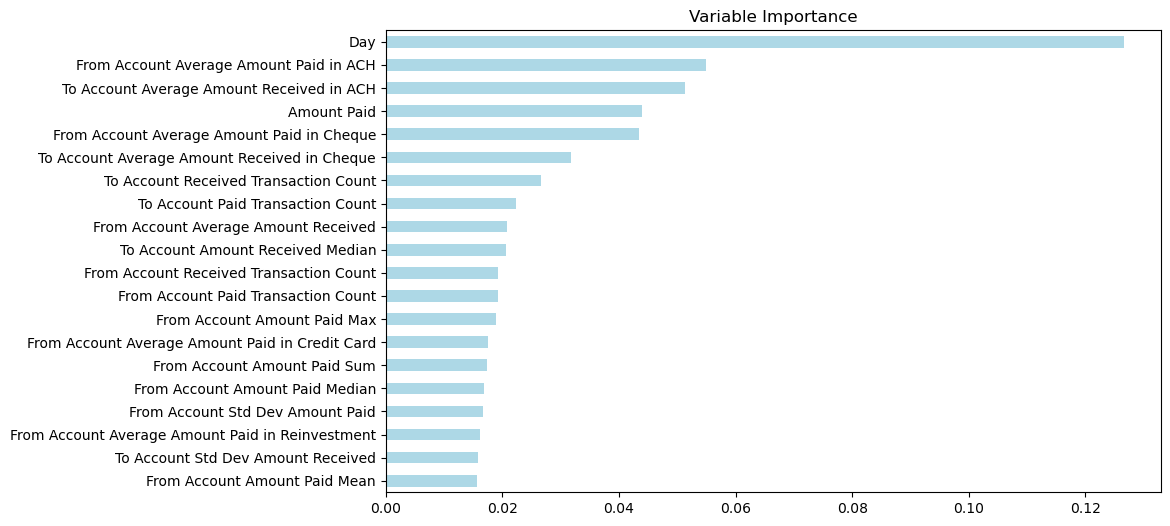

In [23]:
# Define variable names
variable_names = X.columns

# Create a series of variable importances
importances = pd.Series(data=best_rf.feature_importances_,
                        index=variable_names)

# Sort variable importances in descending order and select the 20 most important ones
importances_sorted = importances.sort_values().tail(20)

# Show barplot of variable importances
plt.figure(figsize=(10, 20 * 0.3))
importances_sorted.plot(kind='barh', color='lightblue')                      
plt.title('Variable Importance')
plt.show()

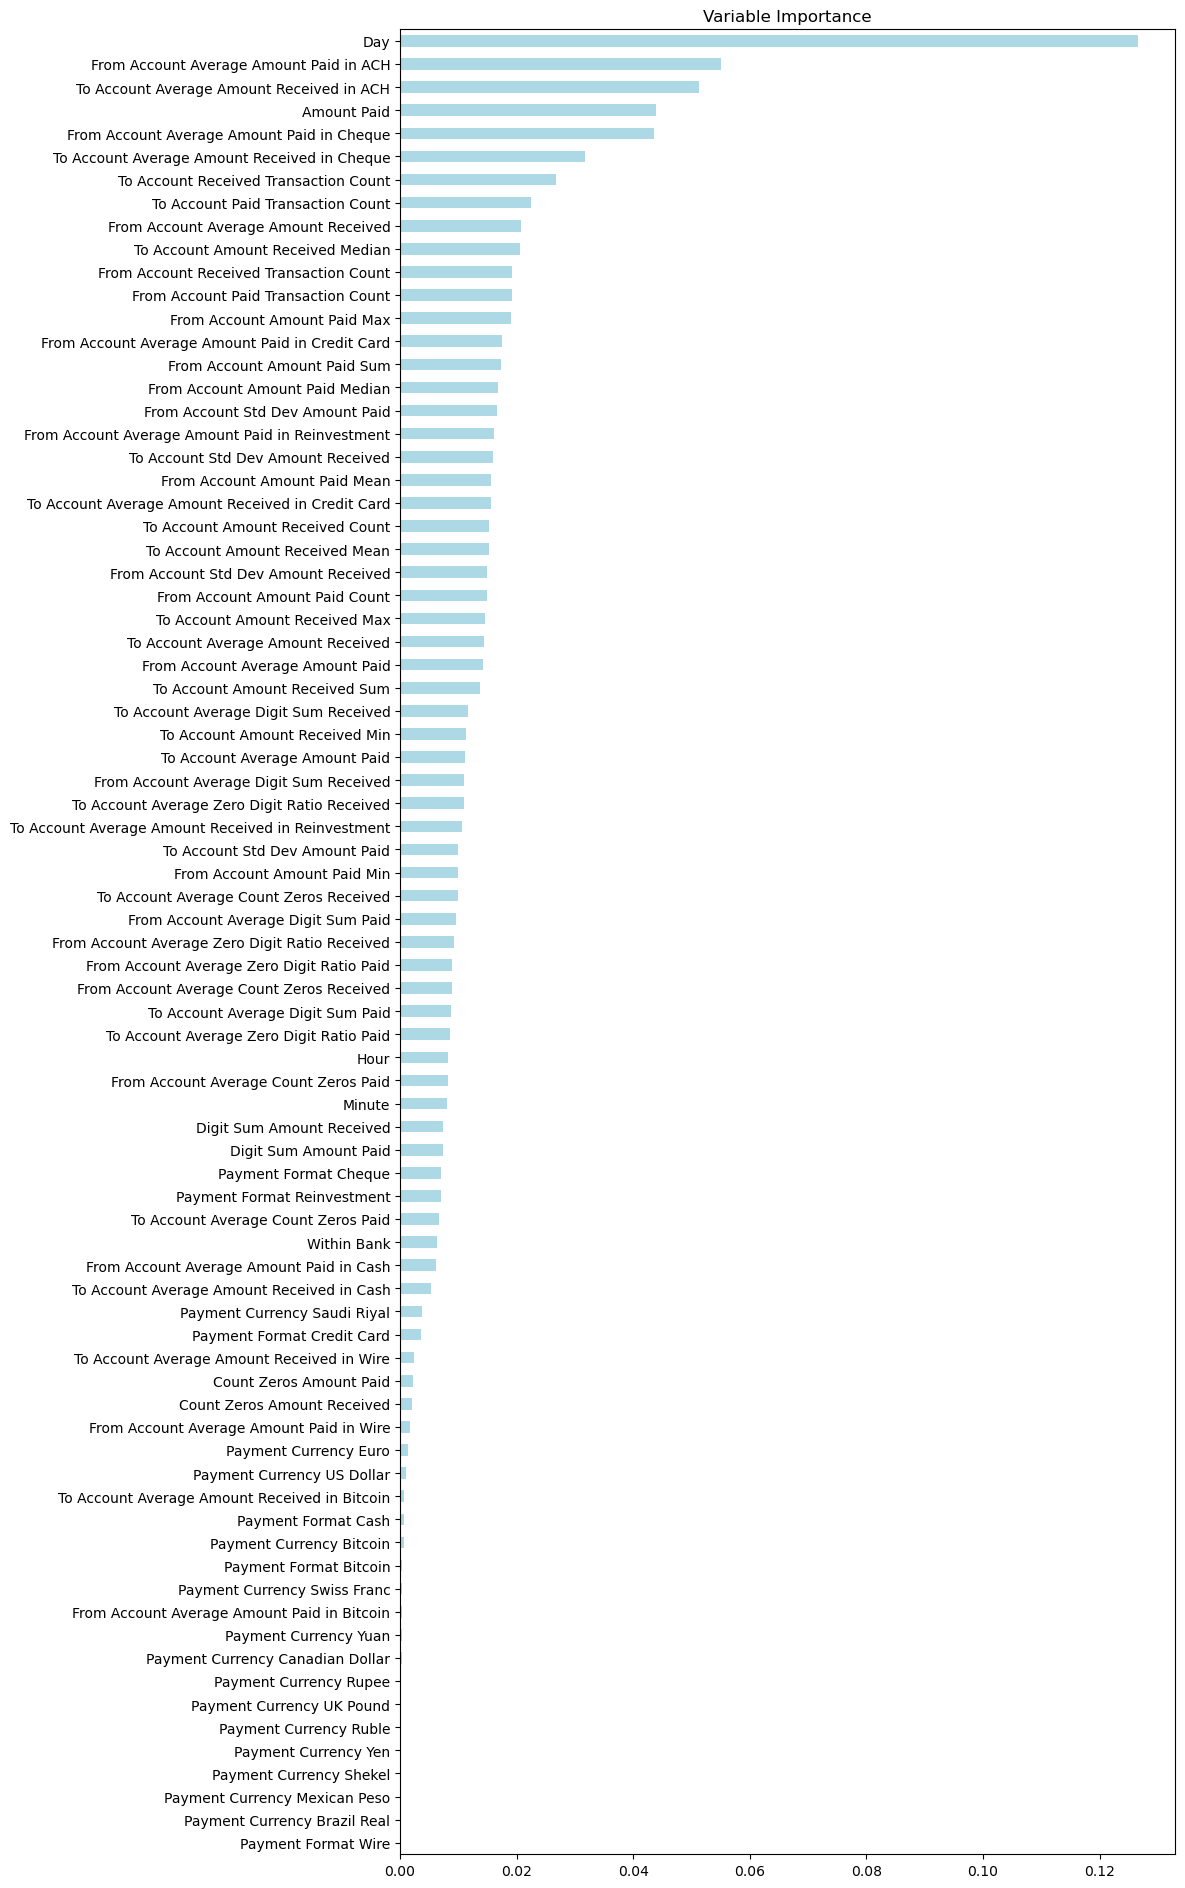

In [24]:
# Sort variable importances in descending order
importances_sorted = importances.sort_values()

# Show barplot of variable importances
plt.figure(figsize=(10, len(importances_sorted) * 0.3))
importances_sorted.plot(kind='barh', color='lightblue')                      
plt.title('Variable Importance')
plt.show()

In [25]:
# Show number of variables
len(importances_sorted)

79

### Select the 20 Most Important Variables

In [26]:
# List the 20 most important variables
importances_sorted[::-1].index[:20]

Index(['Day', 'From Account Average Amount Paid in ACH',
       'To Account Average Amount Received in ACH', 'Amount Paid',
       'From Account Average Amount Paid in Cheque',
       'To Account Average Amount Received in Cheque',
       'To Account Received Transaction Count',
       'To Account Paid Transaction Count',
       'From Account Average Amount Received',
       'To Account Amount Received Median',
       'From Account Received Transaction Count',
       'From Account Paid Transaction Count', 'From Account Amount Paid Max',
       'From Account Average Amount Paid in Credit Card',
       'From Account Amount Paid Sum', 'From Account Amount Paid Median',
       'From Account Std Dev Amount Paid',
       'From Account Average Amount Paid in Reinvestment',
       'To Account Std Dev Amount Received', 'From Account Amount Paid Mean'],
      dtype='object')

In [27]:
# Select the 20 most important variables
columns_to_filter = [
    'Is Laundering','Day', 'From Account Average Amount Paid in ACH',
       'To Account Average Amount Received in ACH', 'Amount Paid',
       'From Account Average Amount Paid in Cheque',
       'To Account Average Amount Received in Cheque',
       'To Account Received Transaction Count',
       'To Account Paid Transaction Count',
       'From Account Average Amount Received',
       'To Account Amount Received Median',
       'From Account Received Transaction Count',
       'From Account Paid Transaction Count', 'From Account Amount Paid Max',
       'From Account Average Amount Paid in Credit Card',
       'From Account Amount Paid Sum', 'From Account Amount Paid Median',
       'From Account Std Dev Amount Paid',
       'From Account Average Amount Paid in Reinvestment',
       'To Account Std Dev Amount Received', 'From Account Amount Paid Mean']

df_sel_var = df_all_var.loc[:, columns_to_filter]
df_sel_var.head()

,Is Laundering,Day,From Account Average Amount Paid in ACH,To Account Average Amount Received in ACH,Amount Paid,From Account Average Amount Paid in Cheque,To Account Average Amount Received in Cheque,To Account Received Transaction Count,To Account Paid Transaction Count,From Account Average Amount Received,To Account Amount Received Median,From Account Received Transaction Count,From Account Paid Transaction Count,From Account Amount Paid Max,From Account Average Amount Paid in Credit Card,From Account Amount Paid Sum,From Account Amount Paid Median,From Account Std Dev Amount Paid,From Account Average Amount Paid in Reinvestment,To Account Std Dev Amount Received,From Account Amount Paid Mean
0,0,1,2058.070954,0.000000,12.677957,0.000000,2.543906e+03,14.0,3.0,3998.701632,12.677957,14.0,3.0,12.677957,0.000000,12.677957,12.677957,1.127012e+03,113.920650,7731.948289,12.677957
1,0,1,2089.542390,0.000000,2977.670116,0.000000,0.000000e+00,2.0,3.0,1493.562942,2977.670116,2.0,3.0,2977.670116,0.000000,2977.670116,2977.670116,1.523473e+03,1493.562942,2098.844493,2977.670116
2,0,1,0.000000,156.286217,74.103124,0.000000,5.899356e+04,41.0,57.0,2089.542390,74.103124,1.0,10.0,74.103124,63.796792,74.103124,74.103124,8.532493e+01,0.000000,69680.093067,74.103124
3,0,1,0.000000,0.000000,13886.360391,0.000000,1.370731e+06,4.0,9.0,0.000000,13886.360391,0.0,1.0,13886.360391,0.000000,13886.360391,13886.360391,1.386710e+06,0.000000,682237.153093,13886.360391
4,0,1,0.000000,0.000000,10.330801,273.557031,1.767892e+02,4.0,30.0,220.575561,10.330801,4.0,30.0,10.330801,0.368601,10.330801,10.330801,7.612480e+02,264.361920,213.488954,10.330801


### Save File with Selected Variables

In [28]:
df_sel_var.to_csv('./df_sel_var.csv', index=False)